# PCA Implementation

### Objective

The objective of this notebook is to create own Python implementation for calculating PCA.

### Tools

We use **Numpy** for handling matrices and vectors but we do not use it to compute anything directly. The objective of this notebook is for me to explore how PCA works by implementing it on my own.

We also use **matplotlib** for creating simple plots.

### Resources

* http://madrury.github.io/jekyll/update/statistics/2017/10/04/qr-algorithm.html

### PCA

We can achieve PCA by forming an eigenvalue decomposition of the data matrix $X^TX$ (normalized means).

#### Calculation pipeline

The pipeline for calculating the eigenvalue decomposition:

Let original data be $D \in {\rm I\!R}^{n \times p}$

0. $X = D - \overline{D} \rightarrow A = X^TX$ 
1. $A = QR$ decomposition (GS -process)
3. Obtain Eigenvectors of $A$

In [11]:
# Imports
import numpy as np
import matplotlib.pyplot as plt

In [12]:
# First step: Normalize with mean row
def normalize(data_matrix):
    mean_row = np.mean(data_matrix, axis=0)
    mean_matrix = np.array([mean_row for _ in range(len(data_matrix))])
    normalized_matrix = data_matrix - mean_matrix
    return normalized_matrix

In [13]:
# The second step: Function for calculating QR decompositions using the GS-process
# This function is used in iteration for the 3rd step.
def GSProcess(A):
    T = A.T
    u_vectors = []
    e_vectors = []
    def projection(index, a_index):
        u = u_vectors[index]
        a = T[a_index]
        c = np.dot(u, a) / np.dot(u, u)
        return c * u
    
    for k in range(len(T)):
        vector_sum = [projection(index, k) for index in range(0, k)]
        new_vector = T[k] - sum(vector_sum)
        u_vectors.append(new_vector)
        e_vectors.append(new_vector / np.linalg.norm(new_vector))
    return np.array(e_vectors).T

In [14]:
# Third step: Schur decomposition by iterating the GSProcess
# Returns eigenvector matrix and eigenvalue diagonal matrix
def Schur(A, steps=100):
    current_a = A
    current_q = np.eye(len(A))
    improvement = 100
    counter = 0
    th = 0.01
    while improvement > th and counter < steps:
        Q = GSProcess(current_a)
        new_a = Q.T @ (current_a @ Q)
        current_a = new_a
        new_q = current_q @ Q if current_q is not None else Q
        improvement = np.linalg.norm(current_q - new_q)
        current_q = new_q
        counter = counter + 1
    return (current_q, current_a)

In [15]:
# 4th step: Get the transformed data
def PCA(data_matrix, num_dimensions=None):
    normalized_matrix = normalize(data_matrix)
    A = normalized_matrix.T @ normalized_matrix
    eigenvectors, value_matrix = Schur(A)
    eigenvalues = np.array([value_matrix[i][i] for i in range(len(value_matrix))])
    Q, V = np.linalg.eig(A)
    sorted_eigenvalue_indices = np.argsort(-eigenvalues)
    if num_dimensions is not None:
        top_eigenvalues = sorted_eigenvalue_indices[:num_dimensions]
        used_eigenvalues = np.array([eigenvalues[i] for i in top_eigenvalues])
        W = np.array([eigenvectors.T[i] for i in top_eigenvalues]).T
    else:
        W = np.array(eigenvectors.T)
    T = normalized_matrix @ W
    return T, normalized_matrix, used_eigenvalues, eigenvalues

### Iris dataset test

In [16]:
filename = "iris_data.csv"
rows = []
labels = []
with open(filename) as f:
    for row in f:
        parts = [el.strip() for el in row.split("\t")]
        if len(parts) == 5:
            parsed = list(map(lambda x: float(x), parts))
            rows.append(parsed[:4])
            labels.append(parts[4])

In [17]:
transformed, n, used_eigenvalues, all_eigenvalues = PCA(rows, 2)
sections = {}
current_section = labels[0]
for i, element in enumerate(transformed):
    l = int(labels[i])
    if l not in sections:
        sections[l] = [element]
    else:
        sections[l].append(element)

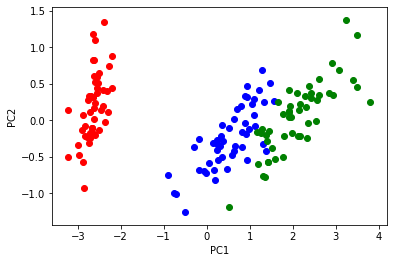

In [18]:
section_colors = ["red", "blue", "green"]

for section_key in sections.keys():
    section_elements = np.array(sections[section_key])
    plt.scatter(section_elements.T[0], section_elements.T[1], c=section_colors[section_key])

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.show()

### Total variance

Total variance proportion "explained" by $k$ principal components:

$$ \text{Var}_{pc} = \frac{\sum_{i=1}^{k} \lambda_{i}}{\sum_{i=1}^{p} \lambda_{i}}$$

$\lambda_{i}$ is eigenvalue of of $A = X^TX$

In [19]:
total_variance = sum(used_eigenvalues) / sum(all_eigenvalues)

In [20]:
total_variance

0.9776316470429075